# Reseaux de Neurones Confolutifs (CNNs)

![GPI-CESI.jpg](attachment:GPI-CESI.jpg)

|Auteur|Centre|Modification|
|---|---|---|
|Nassim HADDAM|Nanterre|2020/12/08|

The aim of this workshop is to introduce you to the basics of convolutional neural networks (CNNs). Convolutional neural networks (CNNs) are a special architecture for learning computer vision tasks. The application you are about to carry out consists in classifying images of flowers. The dataset is provided, and you will be guided through the workshop. You'll be working mainly with [`keras`](https://keras.io/api/), an opensource library for deep learning that has been integrated into [`tensorflow`](https://www.tensorflow.org/). version 2.

# 1. Loading data and building the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We start by downloading the images we're going to use for image classification:

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>  #Image length and width.
    <li>La taille du batch.</li>  #Batch size.
</ul>

In [3]:
image_h = 180    #setting the image length
image_w = 180    #setting the image width
batch_s = 32     # setting the batch size
image_size=(image_h,image_w) #combining the image length and height to be a 2D image size

Ensuite, nous devons partager le jeu de données en jeu d'entrainement et en jeu de test. Pour rappel, le jeu d'entrainement servira à entrainer le réseau de neurones, quant au jeu de test il sert à mesurer les performances de votre architecture sur des données qu'il n'a jamais vues auparavant. Le jeu d'entrainement constitue une fraction du jeu de données total (en l'occurrence 80% dans ce travail). Vous utiliserez la fonction [`tf.keras.preprocessing.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). Cette fonction sert à générer un jeu de données à partir des fichiers d'image dans un répertoire.

**Remarque** : L'algorithme d'apprentissage ne doit **jamais** voir le jeu de test ni s'entrainer sur les exemples le constituant, cela biaiserait les résultats obtenus.


Next, we need to divide the dataset into a training set and a test set. As a reminder, the training set will be used to train the neural network, while the test set will be used to measure the performance of your architecture on data it has never seen before. The training set is a fraction of the total dataset (in this case 80%). You will use the function [`tf.keras.preprocessing.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). This function is used to generate a dataset from image files in a directory.

**Note**: The learning algorithm must **never** see the test set, nor train on its examples, as this would bias the results obtained.




In [4]:
# The train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=image_size,       # Resize images to a consistent size
  batch_size=batch_s)          # Set batch size

# The test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=image_size,
  batch_size=batch_s)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Le sortie précise qu'on a 3670 fichiers au complet dont 2936 appartenant au jeu d'entrainement et 734 au jeu de test. Maintenant que le jeu de données est prêt, il faut explorer/visualiser les données pour avoir une meilleure intuition de ce qui se passe.

# 2. Exploration et visualisation des données
Commençons, tout d'abord par afficher le nom des classes. On sait qu'on s'intéresse aux fleurs, mais on ne sait meme pas lesquelles.



The release states that we have 3670 files in total, 2936 of which belong to the training set and 734 to the test set.
Now that the dataset is ready, it's time to explore/view the data to get a better intuition of what's going on.

# 2. Data exploration and visualization
Let's start by displaying the class names. We know we're interested in flowers, but we don't even know which ones.

In [5]:
class_names =  train_set.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Le résultat et bel et bien affiché. En français, ça donne `['marguerite', 'pissenlit', 'roses', 'tournesols', 'tulipes']`. Affichons ensuite avec [matplotlib.pyplot.subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html) quelques images pour voir à quoi ces classes correspondent.

The result is displayed as `['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']`.  Next, let's use [matplotlib.pyplot.subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html) to display a few images to see what these classes correspond to.   

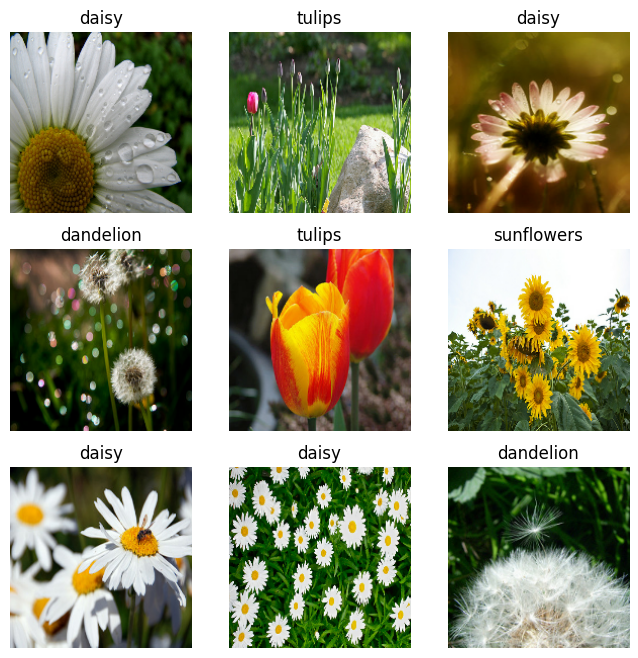

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.title(class_names[labels[i]])  # Set the title to the class name
        plt.axis("off")  # Turn off the axis

On voit bien qu'il y a différents types de fleurs. Il y a, en apparence, un seul type de fleur par image (ce serait compliqué de faire de la classification autrement).

Cependant, on note un certain nombre d'éléments qui peuvent compliquer l'interprétation des images. Une image peut représenter une ou plusieurs fleurs du même type, l'angle de la photo n'est pas toujours le même ainsi que la luminosité, la distance de l'objectif aux fleurs etc. L'arrière-plan peut aussi varier énormément d'une image à l'autre. Enfin, on a aussi parfois d'autres objets dans l'image, qu'ils soient présents dans la nature (abeilles) ou parfois non (sacs). Heureusement, nous avons à notre disposition des outils pour traiter de ce genre de problème, nous le verrons plus bas.

On voudrait aussi connaître la taille des données, ça pourrait être utile pour gérer les performances du modèle. Dans la cellule ci-dessous, le type de `train_set` est [`BatchDataset`](https://www.tensorflow.org/api_docs/python/tf/raw_ops/BatchDataset), c'est un objet contenant les batchs d'images. On prend un élément de `train_set` et on affiche le premier batch. C'est un tenseur (matrice à $n$ dimensions) de la forme (32, 180, 180, 3). Ce tenseur représente un batch de 32 images de dimensions 180x180x3 (la dernière dimension représente les canaux RVB). La variable `label_batch` est un tenseur de la forme (32,), il contient les labels des images du batch.


Clearly, there are different types of flowers. On the face of it, there is only one type of flower per image (it would be complicated to classify otherwise).

However, there are a number of elements that can complicate image interpretation. An image may represent one or more flowers of the same type, the angle of the photo is not always the same, as is the luminosity, the distance from the lens to the flowers, etc. The background can also vary enormously. The background can also vary enormously from one image to another. Last but not least, there are sometimes other objects in the image, whether present in nature (bees) or not (bags). Fortunately, we have tools at our disposal to deal with this kind of problem, as we'll see below.

We'd also like to know the size of the data, which could be useful for managing model performance. In the cell below, the type of `train_set` is [`BatchDataset`](https://www.tensorflow.org/api_docs/python/tf/raw_ops/BatchDataset), an object containing image batches. We take an element from `train_set` and display the first batch. This is a tensor ($n$-dimensional matrix) of the form (32, 180, 180, 3). This tensor represents a batch of 32 images of dimensions 180x180x3 (the last dimension represents the RGB channels). The variable `label_batch` is a tensor of the form (32,), it contains the labels of the images in the batch.

In [7]:
print(type(train_set))
images, labels = train_set.as_numpy_iterator().next()
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(32, 180, 180, 3)
(32,)


Il est maintenant temps de configurer notre environnement pour passer au vif du sujet.

# 3. Configuration de l'environnement pour l'entrainement
Dans cette partie, vous devrez utiliser les fonctions [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) et [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) afin de configurer les données pour améliorer les performances de la façon suivante :
- `Dataset.cache()` : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois.
- `Dataset.prefetch()` : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

Now it's time to configure our environment and get down to business.

# 3. Configuring the training environment
In this section, you'll use the [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) functions to configure the data to improve performance as follows:

- `Dataset.cache()` : This function is used to force data to be cached in memory. As the neural network makes several passes (known as epochs) over the data during training, this function avoids having to reload the images each time.
- `Dataset.prefetch()`: This function preprocesses the current element of the dataset (e.g. the next batch) at the same time as the model trains/evaluates the current batch. In a multi-processor or multi-core environment, this saves considerable time.

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# 4. La normalisation
Généralement, en machine learning, vous aurez souvent besoin de transformer l'échelle de valeur des attributs de sorte que les attributs prennent des valeurs qui sont dans le même intervalle. Cette transformation aura pour effet de rendre l'apprentissage plus uniforme au niveau des différents attributs et donc de ne pas surestimer l'importance d'un attribut par rapport à un autre (cela peut arriver si par exemple les attributs ont des échelles complètement différentes). Dans ce workshop vous allez appliquer [la normalisation](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17) qui consiste juste à diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 pour transformer l'entrée dans l'intervalle [0, 1]. Ce traitement se fait à l'aide de la fonction [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling).

# 4. Normalization
Generally speaking, in machine learning, you will often need to transform the value scale of attributes so that they take values that are in the same interval. This transformation will have the effect of making the learning process more uniform across the different attributes, so that the importance of one attribute is not overestimated in relation to another (this can happen if, for example, the attributes have completely different scales). In this workshop you will apply [normalization](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17), which simply consists of dividing the input (the value of a pixel's RGB component) by 255 to transform the input into the interval [0, 1]. This is done using the function [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling).

# 5. Le modèle de réseau de neurones convolutif (CNN)
# 5. The convolutional neural network (CNN) model
Le CNN est une architecture spécialisée de réseau de neurones qui a été créé afin d’apprendre efficacement les taches de vision par ordinateur. Un exemple de cette architecture est illustré ci-dessous. La particularité de ces réseaux de neurones est l’introduction de couches convolutives au niveau des couches cachées :

- Vous avez vu dans le workshop de traitement d’images que les opérations de convolution servent à extraire divers caractéristiques et informations contenues dans l’image (nous avons vu la détection de [contours]( https://fr.wikipedia.org/wiki/D%C3%A9tection_de_contours), mais il y aussi la détection de [coins]( https://en.wikipedia.org/wiki/Corner_detection), et aussi la détection de [blob]( https://en.wikipedia.org/wiki/Blob_detection)).
- Vous savez aussi depuis le workshop précédent que dans les réseaux de neurones, les neurones des couches profondes se basent sur les neurones des premières couches pour détecter des attributs de plus haut niveau de la donnée en entrée. Pour les images, par exemple, les caractéristiques de bas niveau sont celles mentionnées dans le point précédent (contours, coins, blobs...), et les caractéristiques de haut niveau pourraient être la présence de certaines motifs, textures, formes construites partant des attributs de bas niveau.

The CNN is a specialized neural network architecture created to efficiently learn computer vision tasks. An example of this architecture is shown below. The special feature of these neural networks is the introduction of convolutional layers in the hidden layers:
- You saw in the image processing workshop that convolution operations are used to extract various features and information from the image (we saw edge detection, but there's also corner detection, and also blob detection).
- You'll also know from the previous workshop that, in neural networks, the neurons in the deeper layers build on the neurons in the first layers to detect higher-level attributes of the input data. For images, for example, low-level features are those mentioned in the previous point (contours, corners, blobs...), and high-level features could be the presence of certain patterns, textures, shapes built on low-level attributes.

![convolutional_architecture.png](attachment:convolutional_architecture.png)
Les réseaux de neurones convolutifs combinent les deux idées précédentes pour former des réseaux dont certains neurones servent à représenter des informations plus ou moins locales sur les images à travers l’application de l’opération de convolution. Ces neurones (issus de couches dites convolutives) ne sont connectés qu’à des neurones voisins de la couche précédente. La sortie de ces mêmes neurones est obtenue par l’application de filtres convolués sur la couche précédente. Ces filtres représentent les poids de la couche convolutive et servent à décrire des attributs de l’images appris à partir du dataset. Un exemple de convolution au niveau de la couche convolutive vous est donné ci-dessous (et qui est tiré de ce [lien](https://cs231n.github.io/convolutional-networks/)). Pouvez-vous dire pourquoi il est plus intéressant d’opter pour une architecture par réseaux de neurones convolutifs au lieu de garder l’architecture classique pour les taches de vision par ordinateur ?

Convolutional neural networks combine the two previous ideas to form networks in which certain neurons are used to represent more or less local information on images through the application of the convolution operation. These neurons (from so-called convolutional layers) are connected only to neighboring neurons in the previous layer. The output of these same neurons is obtained by applying convolutional filters to the previous layer. These filters represent the weights of the convolutional layer and are used to describe image attributes learned from the dataset. An example of convolution at the convolution layer level is given below (and taken from this [link](https://cs231n.github.io/convolutional-networks/)). Can you tell us why it is more interesting to opt for a convolutional neural network architecture instead of keeping the classical architecture for computer vision tasks?
![gif_convolution.gif](attachment:gif_convolution.gif)


Après ces discussions théoriques sur les CNNs, passons maintenant au code. Pour coder votre modèle, vous devez tout d'abord créer un modèle vide à l'aide de la fonction [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) de tensorflow. La suite de cette partie vous guidera dans l'implémentation d'un modèle potentiel pour la classification d'image, elle introduira aussi quelques notions sur les réseaux de neurones convolutifs.


After these theoretical discussions on CNNs, let's move on to the code. To code your model, you must first create an empty model using tensorflow's [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) function. The remainder of this section will guide you through the implementation of a potential model for image classification, and introduce a few notions about convolutional neural networks.

In [10]:
# @title Default title text
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche//Number of classes as well as number of neurons in the last layer
model = Sequential()


In Convolutional Neural Networks (CNNs), filter size, padding, and stride are key parameters that define how the convolution operation is performed. These parameters influence the size of the output feature maps and play a critical role in capturing patterns and features from input data. Here's an explanation of each:

1. Filter Size (Kernel Size)
Definition: The filter size refers to the dimensions of the convolutional kernel (filter), which is a small matrix used to apply the convolution operation. Common filter sizes are 3x3, 5x5, or 7x7.

Role: The filter scans over the input image, detecting features such as edges, textures, or patterns. A larger filter size captures more spatial context, while smaller filters focus on more localized details.

Example:

A 3x3 filter looks at a 3x3 region of pixels at a time, while a 5x5 filter looks at a 5x5 region.
Impact:

A larger filter size leads to a smaller output feature map (unless padding is used).
Larger filters are computationally more expensive and may overgeneralize, while smaller filters tend to capture finer details.
Illustration: For a 5x5 input and a 3x3 filter, the result will be a 3x3 feature map (assuming no padding).

2. Padding
Definition: Padding refers to adding extra pixels (usually zeros) around the border of the input image. This ensures that the filter can be applied to the borders of the image as well.

Types of Padding:

Valid Padding (No Padding): No extra pixels are added. The output size is smaller than the input size because the filter can’t fit perfectly at the borders.
Same Padding (Zero Padding): Extra pixels are added such that the output size is the same as the input size after applying the filter.
Impact:

Without padding: The size of the output feature map is reduced after each convolution. For example, a 5x5 input with a 3x3 filter will result in a 3x3 output.
With padding: The size of the output feature map can be preserved. For example, with "same" padding, a 5x5 input and a 3x3 filter will produce a 5x5 output.

3. Stride
Definition: Stride determines how much the filter moves at each step across the input image. A stride of 1 means the filter moves one pixel at a time, while a stride of 2 moves the filter two pixels at a time, effectively reducing the resolution of the output feature map.

Impact:

A larger stride produces smaller output feature maps, as the filter covers fewer locations. This reduces computational complexity but may also lose finer details in the image.
A smaller stride (e.g., stride of 1) produces larger feature maps, preserving more details but increasing computational cost.
Example:

Stride = 1: The filter moves one pixel at a time. If the input is 5x5 and the filter is 3x3, the output will be 3x3.
Stride = 2: The filter moves two pixels at a time. If the input is 5x5 and the filter is 3x3, the output will be 2x2.
Interaction Between Filter Size, Padding, and Stride
Filter Size and Padding: Larger filters without padding can significantly reduce the output size, but with padding (especially "same" padding), the output size can be preserved.

Filter Size and Stride: Large filters combined with large strides will drastically reduce the spatial resolution of the output feature maps. A 3x3 filter with stride 1 results in less reduction compared to stride 2.

Padding and Stride: With padding, the output size can remain the same as the input even when using large filters, while larger strides will reduce the output size regardless of padding.

Summary:
Filter Size: Defines the spatial area the convolution covers; larger filters capture more context but reduce output size.
Padding: Helps control output size, especially at the borders; "same" padding retains the input size.
Stride: Controls how the filter moves; larger strides reduce the resolution of the output feature map.

Généralement, en machine learning, vous aurez souvent besoin de transformer l'échelle de valeur des attributs de sorte que les attributs prennent des valeurs qui sont dans le même intervalle. Cette transformation aura pour effet de rendre l'apprentissage plus uniforme au niveau des différents attributs et donc de ne pas surestimer l'importance d'un attribut par rapport à un autre (cela peut arriver si par exemple les attributs ont des échelles complètement différentes).

Dans ce workshop vous allez appliquer [la normalisation](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17) qui consiste juste à diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 pour transformer l'entrée dans l'intervalle [0, 1]. Vous utiliserez la couche [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) à cet effet.

In general, in machine learning, you will often need to transform the attribute value scale so that the attributes take values that are in the same interval. This transformation will have the effect of making the learning more uniform across the different attributes, and therefore of not overestimating the importance of one attribute compared to another (this can happen if, for example, the attributes have completely different scales).

In this workshop you will apply [normalization](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17), which simply consists of dividing the input (the value of an RGB component of a pixel) by 255 to transform the input into the interval [0, 1]. You'll use the [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer for this purpose.

In [11]:
model.add(
    layers.Rescaling(1/255,input_shape=(image_h,image_w,3))
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Après cela, vous allez implémenter votre premier **bloc convolutif**. Un bloc convolutif est constitué de deux couches spécifiques aux réseaux de neurones convolutifs : la [couche convolutive](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_convolution_(CONV)) (qui a été introduite brièvement), et la [couche de pooling](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_pooling_(POOL)). Pour plus de détails sur ces couches au niveau, [ce Notebook](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb) sera utile. Les architectures gèrent ces couches de manière potentiellement différentes, mais il est courant d'utiliser ces couches de la manière suivante :

- La couche convolutive: Elle sert à détecter la présence d'attributs au niveau de l'image en utilisant l'opération de convolution, et ainsi extraire de plus en plus de caractéristiques. L'application de cette couche vise généralement à retourner des attributs de plus haut niveau sur l'image. Elle a pour effet d’augmenter la profondeur de l’image si le nombre de filtres est assez grand. Dans ce workshop, vous devez faire un [padding](https://ayeshmanthaperera.medium.com/what-is-padding-in-cnns-71b21fb0dd7) de sorte que la taille de la sortie reste la même par rapport à l'entrée. Il devrait y avoir 16 filtres de taille `(3,3)` dans cette première couche. N'oubliez pas que la sortie de cette couche doit être passée à une fonction d'activation (la fonction ReLU).

- La couche de pooling : Elle sert à compresser la sortie de la couche convolutive en prenant l'information la plus saillante de celle-ci. La sortie de la couche convolutive est divisée en blocs carrés de même taille. Pour chaque bloc la valeur maximale est retenue et les autres sont ignorés, la hauteur et la largeur de la couche sont réduites.

Faire passer la sortie d’une couche à un bloc de convolution permet d’un coté de déceler des attributs de plus haut niveau en combinant ceux de la couche précédente, d’un autre côté de réduire le nombre de neurones de façon à prendre les neurones les plus actives et qui sont nécessaires à la tache (grace à la couche de pooling). Vous devez donc ajuter les deux couches en vous référant à la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/). Précisons qu'on vous demande de faire un pooling qui prend le maximum et que l'entrée consiste en des images 2D.


After that, you'll implement your first **convolutional block**. A convolutional block consists of two layers specific to convolutional neural networks: the [convolutional layer](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_convolution_(CONV)) (which was introduced briefly), and the [pooling layer](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_pooling_(POOL)). For more details on these layers at level, [this Notebook](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb) will be useful. Architectures handle these layers in potentially different ways, but it's common to use them as follows:

- The convolution layer: This is used to detect the presence of attributes at the image level using the convolution operation, and thus extract more and more features. The application of this layer is generally aimed at returning higher-level attributes to the image. The effect is to increase the depth of the image if the number of filters is large enough. In this workshop, you need to pad (https://ayeshmanthaperera.medium.com/what-is-padding-in-cnns-71b21fb0dd7) so that the size of the output remains the same as the input. There should be 16 filters of size `(3,3)` in this first layer. Don't forget that the output of this layer must be passed to an activation function (the ReLU function).

- The pooling layer: This is used to compress the output of the convolutional layer by taking the most salient information from it. The output of the convolutional layer is divided into square blocks of equal size. For each block, the maximum value is retained and the others are ignored, while the height and width of the layer are reduced.

Passing the output of a layer to a convolution block allows you, on the one hand, to detect higher-level attributes by combining those of the previous layer, and, on the other hand, to reduce the number of neurons so as to take the most active neurons needed for the task (thanks to the pooling layer). You should therefore add both layers, referring to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/). Note that you're asked to pool the maximum number of neurons and that the input consists of 2D images.

In [12]:
# Couche convolutive
from keras.layers import Conv2D, MaxPooling2D
model.add(
    Conv2D(16, (3,3), activation='relu')
)
# Couche de pooling
model.add(
    MaxPooling2D()
)

Implémentez le reste du réseau. Celui-ci devra contenir les éléments suivants :
- Un bloc convolutif similaire au précédent contenant 32 filtres de hauteur et de largeur de 3.
- Un bloc convolutif similaire au précédent contenant 64 filtres de hauteur et de largeur de 3.
- Une couche contenant la couche précédente aplatie (flatten).
- Une couche entièrement connectée de taille 128.
- La couche finale complètement connectée (dense) retournant le résultat de la classification.

Quelques remarques devront être relevées au sujet de cette architecture, vous pouvez vous appuyer sur le premier schéma de CNN pour suivre les remarques de cette partie :
- Les CNNs sont généralement constitués de deux parties, une partie composée de blocs convolutifs, et une partie composée de couches denses. La première partie sert, indirectement, à compresser la taille de l’image pour la remettre en entrée à la deuxième partie qui aura beaucoup moins de neurones que le nombre d’origine de pixels de l’images.
- Les couches de la partie de blocs convolutifs gagnent en profondeur et perdent en hauteur et en largeur à mesure qu’on avance vers des couches profondes dans le réseau. Nous avons besoin de cela car le réseau a besoin d’apprendre à reconnaitre des attributs descriptifs de l’image pour faire de la classification. Le nombre d’attributs s’accroit à mesure qu’on avance dans le réseau, ceci signifie que les neurones des couches profondes perdent en informations spatiales mais gagnent en information descriptives sur l’image.
Quel est l’intérêt en mémoire et en temps de calcul de l’utilisation des architectures par réseau de neurones convolutifs ? (Intéressez-vous au nombre de paramètres).


Implement the rest of the network. This should contain the following elements:

- A convolutional block similar to the previous one, containing 32 filters of height and width 3.
- A convolutional block similar to the previous one, containing 64 filters of height and width 3.
- A layer containing the previous flattened layer.
- A fully connected layer of size 128.
- The final, fully connected (dense) layer returning the classification result.

There are a few remarks to be made about this architecture, and you can use the first CNN diagram to follow the remarks in this section:
- CNNs are generally made up of two parts, one made up of convolutional blocks, and one made up of dense layers. The first part serves, indirectly, to compress the image size for input to the second part, which will have far fewer neurons than the original number of pixels in the image.
- The layers of the convolutional block part gain in depth and lose in height and width as we move towards deeper layers in the network. We need this because the network needs to learn to recognize descriptive image attributes in order to perform classification. The number of attributes increases as we move deeper into the network, meaning that neurons in the deeper layers lose spatial information but gain descriptive information about the image.

What are the advantages in terms of memory and computation time of using convolutional neural network architectures? (Take an interest in the number of parameters).

1. Fewer Parameters: CNNs dramatically reduce the number of parameters compared to fully connected networks due to shared weights, local connectivity, and sparse interactions. This leads to a more efficient model with lower memory requirements.
2. Faster Computation: Sparse connections, filter reuse, and pooling reduce the number of operations, making CNNs computationally faster than fully connected networks for large inputs like images.
3. Scalability: CNNs scale well to high-dimensional inputs because the number of parameters grows much more slowly than in fully connected layers, allowing the model to handle complex tasks without a proportional increase in memory and computation.

Overall, these properties make CNNs highly efficient in terms of both memory usage and computational speed, enabling them to handle large-scale image data and deep architectures with fewer parameters than fully connected networks.

In [13]:
#metrics of the CNN model
from keras.layers import Dropout,Flatten,Dense
# Bloc convolutif ou la taille du filtre est de (32, 3)//Convolutional block with filter size (32, 3)
model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(image_h,image_w,3)))
model.add(MaxPooling2D())

# Bloc convolutif ou la taille du filtre est de (64, 3)//Convolutional block with filter size (64, 3)
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D())

# Applatissement de la couche//Flatten layer
model.add(Flatten())

# Couche entièrement connectée (couche dense)//Dense layer
model.add(Dense(128,activation='relu'))

# Couche entièrement connectée retournant le résultat de la classification//
#Fully connected layer to return the classification result
model.add(Dense(5,activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Choisissons donc cette métrique et compilons le modèle//Compling the model

In [14]:
from keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam', #A COMPLETER
              loss = 'sparse_categorical_crossentropy', #A COMPLETER
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 89, 89, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 44, 44, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Finalement, vous avez à préciser l'évolution de l'erreur d'entrainement et la comparer à l'erreur de test. Précisons que l'entrainement requiert le jeu d'entrainement, le jeu de test ainsi que le nombre d'époques.//Finally, you need to specify the evolution of the training error and compare it with the test error. Note that training requires the training set, the test set and the number of epochs.


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.3973 - loss: 1.4224 - val_accuracy: 0.5845 - val_loss: 1.0185
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6724 - loss: 0.9027 - val_accuracy: 0.6757 - val_loss: 0.9087
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7525 - loss: 0.6792 - val_accuracy: 0.6553 - val_loss: 0.9427
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8384 - loss: 0.4764 - val_accuracy: 0.6512 - val_loss: 1.0763
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8999 - loss: 0.3067 - val_accuracy: 0.6580 - val_loss: 1.1806
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9623 - loss: 0.1628 - val_accuracy: 0.6662 - val_loss: 1.2215
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9733 - loss: 0.1056 - val_accuracy: 0.6526 - val_loss: 1.3083
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9830 - loss: 0.0739 - val_accuracy: 0.6676 - val

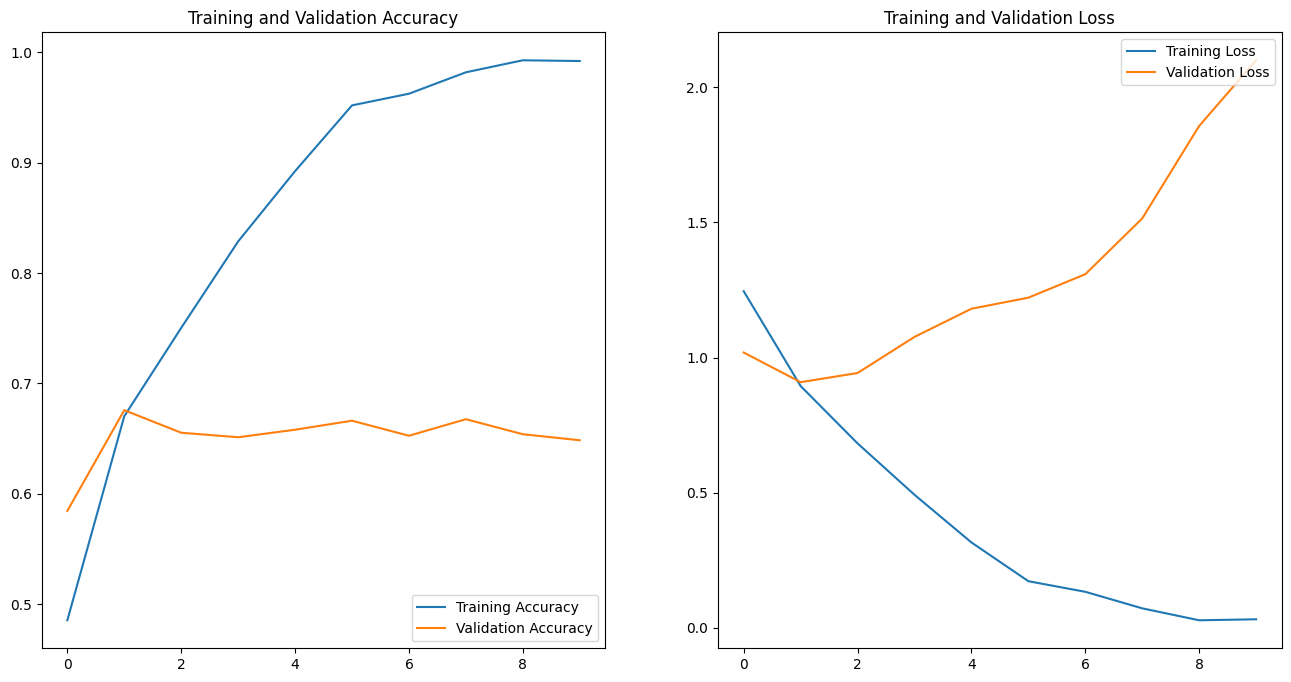

In [15]:
epochs=10
history = model.fit(train_set,validation_data=test_set, epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le code de la cellule précédente permet d’entrainer le modèle et de suivre l’évolution de la précision et de la perte sur le jeu de données d’entrainement et de test. Qu’observez-vous au niveau de ces courbes ? Vous y voyez des signes de surentrainement ou de sous-entrainement ? Pourquoi ?


0n remarque que l’évolution des courbes est assez lisse, que feriez-vous si les courbes étaient très bruitées ?


Il va donc falloir améliorer les performances de notre algorithme d'apprentissage, et notamment gérer ce problème d'apprentissage. Voyons comment on pourrait s'y prendre.//

The code in the previous cell is used to train the model and track the evolution of accuracy and loss over the training and test datasets. What do you see in these curves? Do you see any signs of over-training or under-training? Why or why not?
*There signs of over-fitting as the loss function in the testing set is greater than that in the training set. Moreover accuracy is greatly reduced in the testing set compared to the training set. *

We notice that the curves are fairly smooth. What would you do if the curves were very noisy?<br>
*Add dropout rate or learning rate*


So we're going to have to improve the performance of our learning algorithm, and deal with this learning problem in particular. Let's see how we might go about it.



# 6. Techniques de régularisation
Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones. Dans le cadre de ce wokrshop nous verrons deux techniques de régularisation :
-	**L’augmentation des données** : Avoir plus de données est toujours bon pour réduire le surapprentissage, d’où l’augmentation des données. Le principe et de rajouter de nouvelles images en effectuant des transformations sur le jeu d’entrainement d’origine. Ces nouvelles images sont obtenues par des transformation affines, ou généralement par des transformations réalistes qui ne change pas la nature du label affectée à l’image. Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.
-	**La technique de dropout** : Cette technique consiste à désactiver, à chaque traitement, les neurones d’une couche dense du réseau de manière aléatoire. Le dropout dépend d’un paramètre qui représente la probabilité de désactivation des neurones de la couche. Cette probabilité est le la proportion moyenne de neurones actives dans la couche durant les itérations de l’entrainement. Elle permet de réduire la complexité du réseau de neurones pour réduire le surapprentissage.

Ces techniques sont utilisés afin de réduire le surapprentissage au niveau des réseaux de neurones. Mais pouvez dire pourquoi l’augmentation des données est utile alors que les données générées sont issues du jeu de données d’entrainement ? Il y aurait vraiment plus d’information contenue dans notre jeu de données que celle qui est déjà présente ? Essayez de prendre un exemple d'image et de réfléchir sur ce qui pourrait se passer si on applique une rotation au niveau de cette image.


Pouvez-vous détailler en quoi le dropout est utile pour gérer les problèmes de surapprentissage ? Quels sont les avantages du dopout ? Il faut penser en termes de taille du modèle et de sa capacité à mémoriser/apprendre les détails spécifiques au jeu de données.

Dans les cellules qui suivent, vous allez ré-implémenter le modèle et refaire l’entrainement en incluant une couche de dropout (précédent la couche d’aplatissement), le tout en rajoutant une couche d’augmentation de données. Implémentez tout d'abord le réseau précédent en rajoutant seulement le dropout. //

Regularization techniques are designed to reduce overlearning. The aim is to prevent the neural network from memorizing the data set by foolishly adjusting itself to the particularities of the training set. The overall aim is to reduce the neural network's degrees of freedom. In this wokrshop, we'll look at two regularization techniques:
- **Data augmentation** : Having more data is always a good way of reducing overlearning, hence data augmentation. The principle is to add new images by performing transformations on the original training set. These new images are obtained by affine transformations, or generally by realistic transformations that do not change the nature of the label assigned to the image. This technique is very effective, as neural networks are very data-intensive.
- **The dropout technique**: This technique consists in randomly deactivating the neurons of a dense layer of the network at each processing step. The dropout depends on a parameter representing the probability of deactivation of the neurons in the layer. This probability is the average proportion of active neurons in the layer during training iterations. It is used to reduce the complexity of the neural network in order to reduce overlearning.

These techniques are used to reduce overlearning in neural networks. But can you say why data augmentation is useful when the data generated comes from the training dataset? Would there really be more information contained in our dataset than is already there? Try taking an example image and thinking about what might happen if we applied a rotation to it.

Can you explain in detail how dropout is useful for managing overlearning problems? What are the advantages of dropout? Think in terms of model size and its ability to memorize/learn details specific to the dataset.<br>
Dropout is a powerful and simple regularization technique that addresses the overfitting problem by randomly deactivating neurons during training, thereby preventing the network from over-relying on any specific set of neuron

**Why Dropout is Effective for Managing Overfitting**:
1. Reduces Neuron Co-adaptation: In large neural networks, neurons tend to co-adapt to each other, meaning certain neurons work together to recognize specific features. This can cause the model to become highly tuned to the training data, leading to overfitting.Dropout reduces co-adaptation because a neuron cannot depend on the presence of specific other neurons during training. This encourages neurons to learn more independent, useful features that are robust and generalizable.
2. Implicit Ensemble Learning: By dropping out different subsets of neurons at each training step, dropout effectively creates an ensemble of different subnetworks. Each training iteration can be thought of as training a slightly different network, and at test time, these "subnetworks" are averaged.This ensemble effect improves generalization by combining the predictions of many smaller networks, which are less likely to overfit compared to a single large network.
3. Reduces Model Over-Complexity: Dropout acts like a form of model averaging that reduces the effective size of the model during training. By dropping neurons randomly, the network becomes smaller, preventing it from becoming too complex and memorizing the training data.Since the model must perform well with fewer neurons, it reduces the likelihood of overfitting to the specific training set.
4. Sparsity and Redundancy: When dropout is applied, the model tends to learn redundant representations of the data. Each neuron must be capable of learning without depending on other neurons, leading to more robust feature extraction.This redundancy leads to a sparser model, where each neuron contributes meaningfully to the overall prediction, rather than relying on any one subset of neurons.


**Advantages of Dropout:**
1. Prevents Overfitting: The primary advantage of dropout is its ability to prevent overfitting by ensuring that the network does not become too reliant on specific neurons or patterns in the training data. This leads to a more generalizable model that performs well on unseen data.
2. Simplifies the Model:Dropout effectively reduces the size and complexity of the model during training by deactivating random neurons. A less complex model is less likely to overfit because it cannot memorize every detail of the training set.
3. Regularization Without Extra Computation:Unlike other regularization techniques (e.g., L1 or L2 regularization), dropout does not require extra computation beyond disabling neurons. It’s simple to implement and efficient in practice.
4. Efficient Ensemble Learning: Dropout creates an implicit ensemble of different subnetworks during training, which is much more computationally efficient than explicitly training multiple models. At inference time, all neurons are used, providing a smooth, averaged output.
5. Applicable to Different Layers: Dropout can be applied to fully connected layers, convolutional layers, and even recurrent neural networks. This flexibility makes it a widely used and powerful tool in various types of neural networks.
6. Improves Training with Large Datasets: When dealing with large datasets, dropout helps regularize the model and prevents it from overfitting on small portions of the data, allowing the network to capture general patterns across the entire dataset.

**Limitations of Dropout**:
1. Slower Convergence: Since dropout removes random neurons during training, the convergence process may be slower compared to a model without dropout. The network has to "work harder" to find patterns because it is effectively using fewer neurons.
2. Not Always Beneficial for Small Datasets: In cases where the dataset is very small, dropout can sometimes harm performance because it might prevent the model from fully utilizing its capacity to learn the limited amount of data.
3. Not Optimal for All Network Architectures: In certain architectures like convolutional neural networks (CNNs), dropout may not be as effective because CNNs already have strong regularization properties due to local receptive fields and parameter sharing. Dropout may still be used in the fully connected layers of CNNs, but its use in convolutional layers is less common.

Summary:
- Dropout is a powerful and simple regularization technique that addresses the overfitting problem by randomly deactivating neurons during training, thereby preventing the network from over-relying on any specific set of neurons.
- Advantages include reducing overfitting, simplifying the model, encouraging redundancy, and enabling efficient ensemble learning.
- Key Idea: Dropout forces the model to learn more robust, generalizable features by ensuring that neurons cannot co-adapt to each other, thus improving the model’s ability to handle unseen data.*

In the cells that follow, you will re-implement the model and redo the training by including a dropout layer (preceding the flattening layer), all the while adding a data augmentation layer. First implement the previous network, adding only the dropout.



Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.2567 - loss: 633.0284 - val_accuracy: 0.3678 - val_loss: 1.4956
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.5116 - loss: 1.2689 - val_accuracy: 0.3869 - val_loss: 1.5535
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7157 - loss: 0.8034 - val_accuracy: 0.3951 - val_loss: 1.6535
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8156 - loss: 0.5359 - val_accuracy: 0.4387 - val_loss: 2.1832
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8938 - loss: 0.3377 - val_accuracy: 0.4401 - val_loss: 2.4864
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9257 - loss: 0.2549 - val_accuracy: 0.4455 - val_loss: 2.9912
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9536 - loss: 0.1509 - val_accuracy: 0.4278 - val_loss: 3.5463
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9610 - loss: 0.1320 - val_accuracy: 0.4237 -

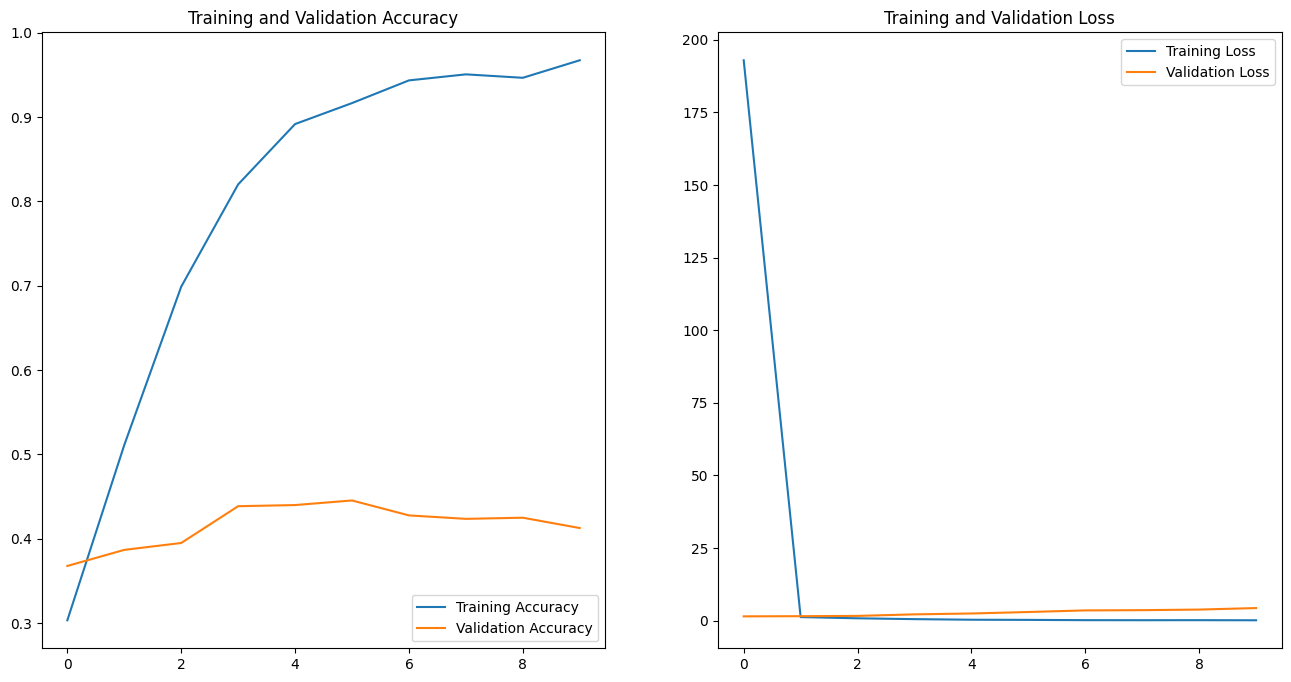

In [16]:
# Le modèle //model_with_dropout
# Set parameters
input_shape = (image_h,image_w,3)  # Example input shape
num_classes = 5  # Change according to your dataset
dropout_rate = 0.1  # Dropout rate

# Define the CNN model
model = Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(dropout_rate))  # Dropout layer

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(dropout_rate))  # Dropout layer

# Flatten the output
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(dropout_rate))  # Dropout layer before output

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Change to 'categorical_crossentropy' if using one-hot encoded labels
              metrics=['accuracy'])

history = model.fit(train_set,validation_data=test_set, epochs=epochs)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Qu'observe-ton au niveau de la perte et de la précision ?

Passons donc à l'augmentation de données. La couche correspondante vous est fournie ci-dessous. Cette couche parcourt le jeu de données d’entrainement et applique des transformations sur certaines images choisies aléatoirement pour augmenter le jeu de données. On peut imaginer plusieurs types de modifications, en l'occurrence les transformations qu'on va appliquer à chaque image selon une certaine probabilité sont un inversement horizontale de l’image suivi d’une rotation de 18 degrés pour finir avec un zoom vertical de 10%. Complétez-la puis exécutez-la.

What do we observe in terms of loss and precision?
The loss drastically reduces in the training set but in the testing set the loss is relatively low throughout.

So let's move on to data augmentation. The corresponding layer is provided below. This layer goes through the training dataset and applies transformations to some randomly selected images to augment the dataset. We can imagine several types of modifications, in this case the transformations that we will apply to each image according to a certain probability are a horizontal inversion of the image followed by an 18 degree rotation to finish with a 10% vertical zoom. Complete it and then run it.

In [18]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", # horizontal flip
    input_shape=(image_h, image_w, 3)),
    layers.RandomRotation(0.1),  # Rotate images by 10% (18 degree rotation),
    layers.RandomZoom(0.1),  # Zoom images by 10% vertically
  ]
)

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

Add the increased data to your CNN and check the curves obtained after training and evaluating the model.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,167,818 (57.86 MB)

 Trainable params: 15,167,818 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.3084 - loss: 2.4324 - val_accuracy: 0.5109 - val_loss: 1.1209
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.5235 - loss: 1.1155 - val_accuracy: 0.6022 - val_loss: 1.0328
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.5937 - loss: 1.0136 - val_accuracy: 0.6076 - val_loss: 0.9827
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.6291 - loss: 0.9385 - val_accuracy: 0.6376 - val_loss: 0.9629
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6537 - loss: 0.8814 - val_accuracy: 0.6417 - val_loss: 0.9734
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6908 - loss: 0.8363 - val_accuracy: 0.6567 - val_loss: 0.8723
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.7063 - loss: 0.7817 - val_accuracy: 0.6649 - val_loss: 0.8688
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.7249 - loss: 0.7055 - val_accuracy: 0.6744 - v

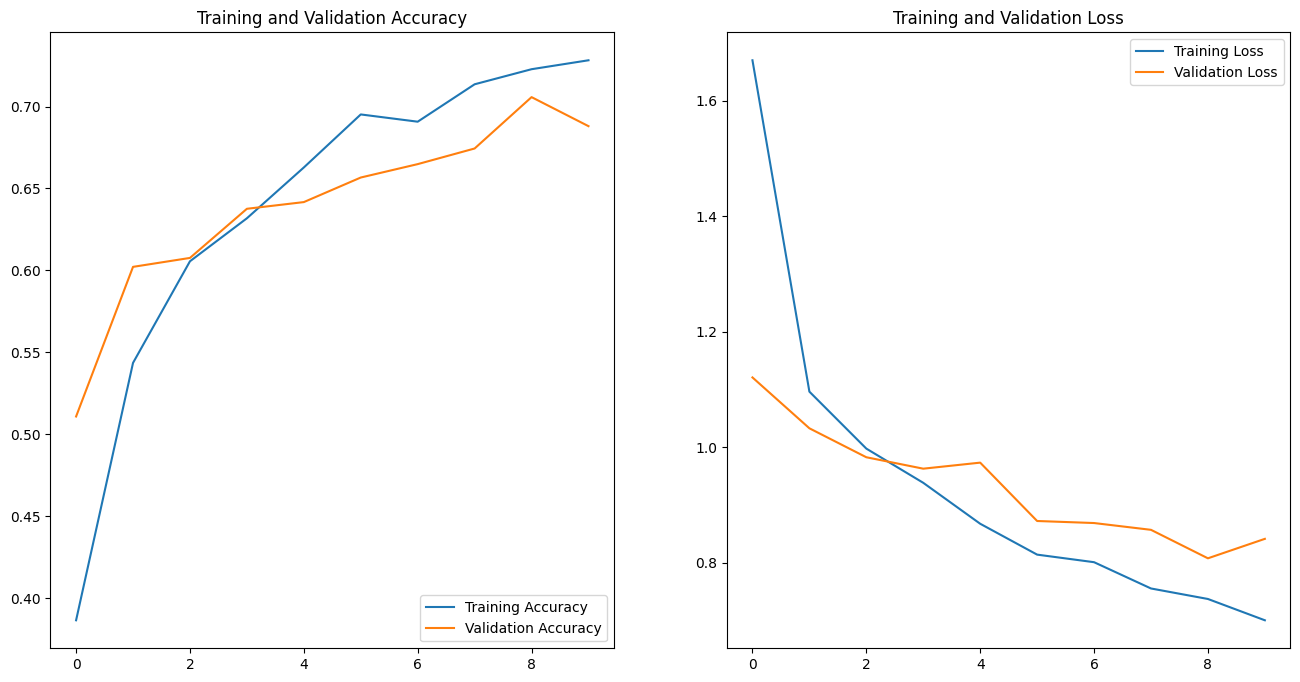

In [19]:
# Le modèle
complete_model = Sequential()
complete_model.add(data_augmentation) # Adding the data augmentation layer (nothing complex is added)
complete_model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))
complete_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
complete_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
complete_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
complete_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
complete_model.add(layers.Flatten())
complete_model.add(layers.Dropout(0.5)) # adding the dropout layer after the flatten layer
complete_model.add(layers.Dense(128, activation='relu'))
complete_model.add(layers.Dense(10, activation='softmax'))
# Compilating the modèle
complete_model.compile(optimizer='adam',  loss='sparse_categorical_crossentropy',  metrics=['accuracy'])
#Model summary
complete_model.summary()
#Model training
history = complete_model.fit(train_set,
                             validation_data=test_set,
                             epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Nous observons cette fois une nette amélioration des performances, la précision dans le jeu de test atteint une valeur proche de la précision dans le jeu d’entrainement, et la perte du jeu de test baisse de façon quasi continuelle au cours de l’entrainement. Voilà une bonne nouvelle. Que remarquez-vous

This time we're seeing a clear improvement in performance, with accuracy in the test set approaching the accuracy in the training set, and loss in the test set dropping almost continuously during training. That's good news. What else do you notice?


# 7. Conclusion

Bravo, Vous venez de réaliser votre premier CNN ! Vous avez vu comment implémenter, entrainer et évaluer un CNN ainsi qu’améliorer ses performances grâce à la régularisation. Félicitations !

Mais il vous reste encore beaucoup à apprendre. Tout d'abord, la précision qu'on obtient n’est que de 73% (celle-ci peut être très proche des 100% pour des jeux de données comme MNIST). Ceci n’est pas étonnant vue la taille de votre réseau qui est très petite (le nombre de paramètres des RNs de Google, par exemple, peut atteindre le million voire le milliard).

Évidemment, augmenter la taille du réseau va nettement impacter la rapidité de l'apprentissage. Dans ce cas, l'usage de GPU performants peut améliorer vos performances de manière drastiques, ceux-ci sont très efficaces pour exécuter des  taches de vision. TensorFlow le fait par défaut, mais il est parfois nécessaire d'adapter son fonctionnement, comme par exemple sélectionner le bon GPU (notamment si vous avez un CPU avec un GPU intégré, en général peu performant, et un GPU externe plus puissant). Vous devriez pouvoir trouverfacilement des [ressources abordant le sujet](https://stackoverflow.com/questions/53065420/by-default-does-tensorflow-use-gpu-cpu-simultaneously-for-computing-or-gpu-only).

Il y aurait surement d'autres approches pour améliorer les résultats. Il exister des arhitectures plus évoluées de CNNs, comme par exemple ResNet, qui connecte des couches profondes avec des couches mois profondes.

Et puis, ici on n'a abordé qu’une seule tache de vision par ordinateur, la classification. Or, c'est la plus simple, et celle-ci est rarement utile à elle seule dans un contexte applicatif (comme pour les voitures autonomes, par exemple). Il y a beaucoup d’autres taches de vision par ordinateur toutes plus difficiles les unes que les autres, comme la détection d’objets (mettre des boites et des labels autour des objets), la segmentation d’image (classifier chaque pixel), la reconnaissance faciale, la restauration d’images etc.//

Congratulations, you've just completed your first CNN! You've seen how to implement, train and evaluate a CNN, as well as improve its performance through regularization. Congratulations!

But you still have a lot to learn. First of all, the accuracy you get is only 73% (it can be very close to 100% for datasets like MNIST). This is not surprising given the size of your network, which is very small (the number of parameters in Google's RNs, for example, can reach a million or even a billion).

Obviously, increasing the size of the network will have a significant impact on learning speed. In this case, the use of high-performance GPUs can drastically improve performance, as they are very efficient for executing vision tasks. TensorFlow does this by default, but it is sometimes necessary to adapt its operation, such as selecting the right GPU (especially if you have a CPU with an integrated GPU, which is generally not very powerful, and a more powerful external GPU). You should easily be able to find resources on the subject.

There may be other approaches to improving results. There are more advanced arhitectures of CNNs, such as ResNet, which connects deep layers with shallower layers.

Besides, we've only dealt with one computer vision task here: classification. But this is the simplest, and is rarely useful on its own in an application context (such as for autonomous cars, for example). There are many other computer vision tasks, each more difficult than the last, such as object detection (putting boxes and labels around objects), image segmentation (classifying each pixel), facial recognition, image restoration and so on.